<a href="https://colab.research.google.com/github/Andrian0s/ML4NLP1-2024-Tutorial-Notebooks/blob/main/tutorials_notebooks_in_class_2024/W06_similarity_analogy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook.

In [1]:
!pip install d2l==1.0.3 matplotlib scikit-learn -qU

# Word Similarity and Analogy

In Exercise 2, we trained a word2vec model on a small dataset, and applied it to find semantically similar words
for an input word. In practice, word vectors that are pretrained on large corpora can be
applied to downstream natural language processing tasks,
which will be covered later. To demonstrate the semantics of pretrained word vectors from large corpora in a straightforward way, let's apply them in the word similarity and analogy tasks.


In [2]:
import os
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

## Loading Pretrained Word Vectors

Below lists pretrained GloVe embeddings of dimension 50, 100, and 300,
which can be downloaded from the [GloVe website](https://nlp.stanford.edu/projects/glove/).
The pretrained fastText embeddings are available in multiple languages.
Here we consider one English version (300-dimensional "wiki.en") that can be downloaded from the
[fastText website](https://fasttext.cc/).


### Difference b/w fastText and Word2Vec

1. fastText works on subwords, i.e. splits words. W2V works on word level
2. fastText can provide embeddings for out-of-vocabulary words. Can handle rare words.
3. Because fastText splits the words, it generally takes longer to train

In [3]:
#save
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip',
                                '0b8703943ccdb6eb788e6f091b8946e82231bc4d')

#save
d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL + 'glove.6B.100d.zip',
                                 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')

#save
d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL + 'glove.42B.300d.zip',
                                  'b5116e234e9eb9076672cfeabf5469f3eec904fa')

#save
d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL + 'wiki.en.zip',
                           'c1816da3821ae9f43899be655002f6c723e91b88')

To load these pretrained GloVe and fastText embeddings, we define the following `TokenEmbedding` class.


In [4]:
class TokenEmbedding:
    """Token Embedding."""
    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    # Function to load embeddings
    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        # GloVe website: https://nlp.stanford.edu/projects/glove/
        # fastText website: https://fasttext.cc/
        with open(os.path.join(data_dir, 'vec.txt'), 'r') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # Skip header information, such as the top row in fastText
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

Below we load the
50-dimensional GloVe embeddings
(pretrained on a Wikipedia subset).
When creating the `TokenEmbedding` instance,
the specified embedding file has to be downloaded if it
was not yet.


In [5]:
glove_6b50d = TokenEmbedding('glove.6b.50d')

Output the vocabulary size. The vocabulary contains 400000 words (tokens) and a special unknown token.


In [6]:
len(glove_6b50d)

400001

We can get the index of a word in the vocabulary, and vice versa.


In [7]:
glove_6b50d.token_to_idx['beautiful'], glove_6b50d.idx_to_token[3367]

(3367, 'beautiful')

We get the word embeddings using the index of the word

In [8]:
glove_6b50d.idx_to_vec[3367], glove_6b50d.idx_to_vec[3367].shape

(tensor([ 0.5462,  1.2042, -1.1288, -0.1325,  0.9553,  0.0405, -0.4786, -0.3397,
         -0.2806,  0.7176, -0.5369, -0.0046,  0.7322,  0.1210,  0.2809, -0.0881,
          0.5973,  0.5526,  0.0566, -0.5025, -0.6320,  1.1439, -0.3105,  0.1263,
          1.3155, -0.5244, -1.5041,  1.1580,  0.6880, -0.8505,  2.3236, -0.4179,
          0.4452, -0.0192,  0.2897,  0.5326, -0.0230,  0.5896, -0.7240, -0.8522,
         -0.1776,  0.1443,  0.4066, -0.5200,  0.0908,  0.0830, -0.0220, -1.6214,
          0.3458, -0.0109]),
 torch.Size([50]))

Function to plot word embeddings. We reduce the embedding dimension of embeddings from 50 to 2 using PCA

In [9]:
def plot_vectors(words, embed):
    word_vectors = embed[words]
    # Apply PCA to reduce dimensions to 2D
    pca = PCA(n_components=2)
    word_vecs_2d = pca.fit_transform(word_vectors)

    # Check how much variance is explained by the 2 components
    explained_variance_ratio = pca.explained_variance_ratio_
    total_explained_variance = explained_variance_ratio.sum()

    print("Explained variance in 2 dimensions: ", np.round(total_explained_variance, 2))
    # Plot the vectors
    plt.figure(figsize=(6, 6))
    plt.scatter(word_vecs_2d[:, 0], word_vecs_2d[:, 1], marker='o', color='red')

    # Annotate each point with its corresponding word
    for i, word in enumerate(words):
        plt.annotate(word, xy=(word_vecs_2d[i, 0], word_vecs_2d[i, 1]), fontsize=12)

    x_min = min(0, word_vecs_2d[:, 0].min()) - 1
    x_max = word_vecs_2d[:, 0].max() + 1
    y_min = min(0, word_vecs_2d[:, 1].min()) - 1
    y_max = word_vecs_2d[:, 1].max() + 1

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title('Word Vectors in 2D (via PCA)')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.grid(True)
    plt.show()

## Applying Pretrained Word Vectors

Using the loaded GloVe vectors,
we will demonstrate their semantics
by applying them
in the following word similarity and analogy tasks.


### Word Similarity

In order to find semantically similar words
for an input word
based on cosine similarities between
word vectors,
we implement the following `knn`
($k$-nearest neighbors) function.


$$ \cos(\theta) = \frac{\mathbf{a} \cdot \mathbf{b}}{|\mathbf{a}| |\mathbf{b}|} $$


$\mathbf{a} \cdot \mathbf{b}$ is the dot product of vectors
a and b. $|\mathbf{a}|$ and $|\mathbf{b}|$ represent the magnitudes of vectors $\mathbf{a}$ and $\mathbf{b}$

In [10]:
def knn(W, x, k):
    # Add 1e-9 for numerical stability
    cos = torch.mv(W, x.reshape(-1,)) / (
        torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) *
        torch.sqrt((x * x).sum()))
    _, topk = torch.topk(cos, k=k)
    return topk, [cos[int(i)] for i in topk]

Demonstrating torch.mv functionality: Dot product b/w rows of Matrix m and a vector v

In [11]:
A = torch.tensor([[1,2,3,4],[5,6,7,8]])
b = torch.tensor([9,10,11,12])
result = torch.mv(A, b)
result # tensor([110, 278])
# 110 = 1*9 + 2*10 + 3*11 + 4*12
# 278 = 5*9 + 6*10 + 7*11 + 8*12

tensor([110, 278])

Then, we
search for similar words
using the pretrained word vectors
from the `TokenEmbedding` instance `embed`.


In [12]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]):  # Exclude the input word
        print(f'cosine sim={float(c):.3f}: {embed.idx_to_token[int(i)]}')

We could also find the cosine distance between any two words using the function below

In [13]:
def get_cosine_similarity(token_a, token_b, embed):
    idx_a = embed.token_to_idx[token_a]
    idx_b = embed.token_to_idx[token_b]
    vec_a = embed.idx_to_vec[idx_a]
    vec_b = embed.idx_to_vec[idx_b]
    cos = torch.dot(vec_a, vec_b)/(torch.norm(vec_a) * torch.norm(vec_b))
    print("Cosine similarity: ", np.round(cos.item(),4))

The vocabulary of the pretrained word vectors
in `glove_6b50d` contains 400000 words and a special unknown token.
Excluding the input word and unknown token,
among this vocabulary
let's find
three most semantically similar words
to word "chip".


In [14]:
get_similar_tokens('chip', 3, glove_6b50d)

cosine sim=0.856: chips
cosine sim=0.749: intel
cosine sim=0.749: electronics


In [15]:
get_cosine_similarity('chip', 'nvidia', glove_6b50d)

Cosine similarity:  0.437


Explained variance in 2 dimensions:  0.73


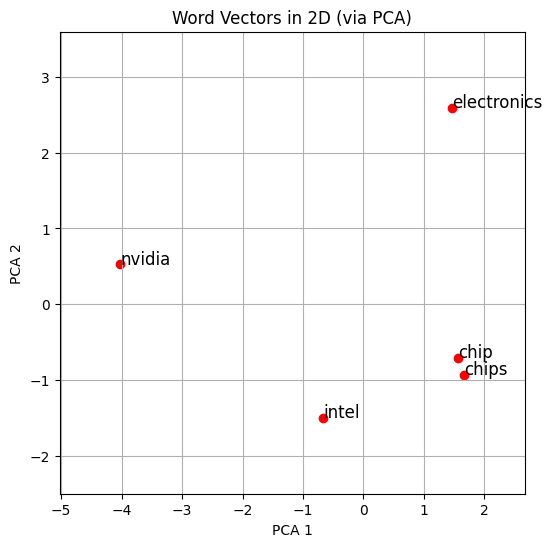

In [16]:
plot_vectors(['chip','chips','intel','electronics','nvidia'], glove_6b50d)

In [18]:
get_similar_tokens('gpu', 3, glove_6b50d)

cosine sim=0.789: nvidia
cosine sim=0.740: gpus
cosine sim=0.709: aes


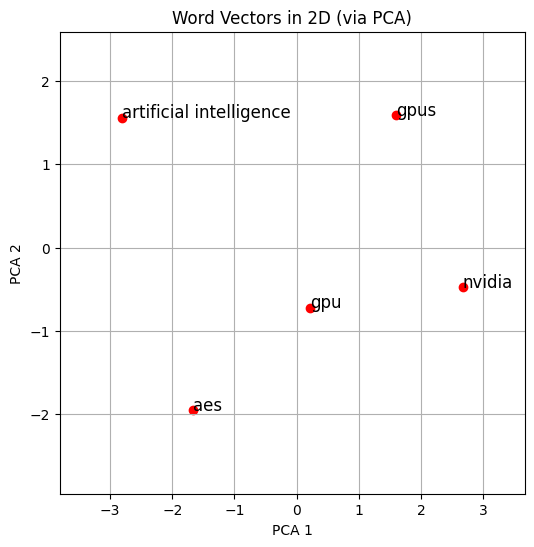

In [19]:
plot_vectors(['gpu','nvidia','gpus', 'aes', 'artificial intelligence'], glove_6b50d)

Below outputs similar words
to "baby" and "beautiful".


In [17]:
get_similar_tokens('baby', 3, glove_6b50d)

cosine sim=0.839: babies
cosine sim=0.800: boy
cosine sim=0.792: girl


Explained variance in 2 dimensions:  0.85


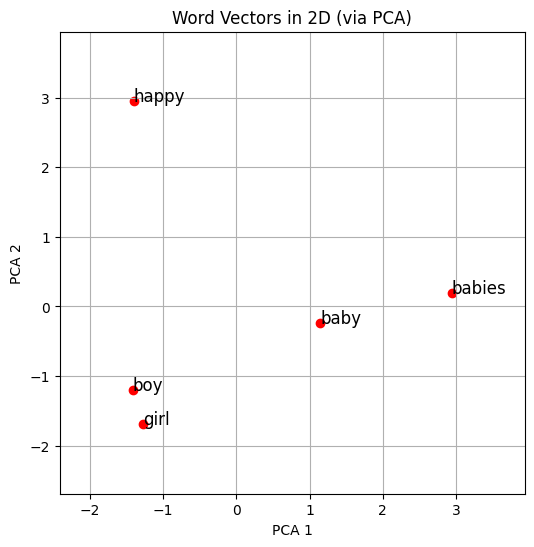

In [18]:
plot_vectors(['baby','babies','boy','girl','happy'], glove_6b50d)

In [19]:
get_similar_tokens('beautiful', 3, glove_6b50d)

cosine sim=0.921: lovely
cosine sim=0.893: gorgeous
cosine sim=0.830: wonderful


In [20]:
get_cosine_similarity('beautiful','switzerland',glove_6b50d)

Cosine similarity:  0.1123


Explained variance in 2 dimensions:  0.91


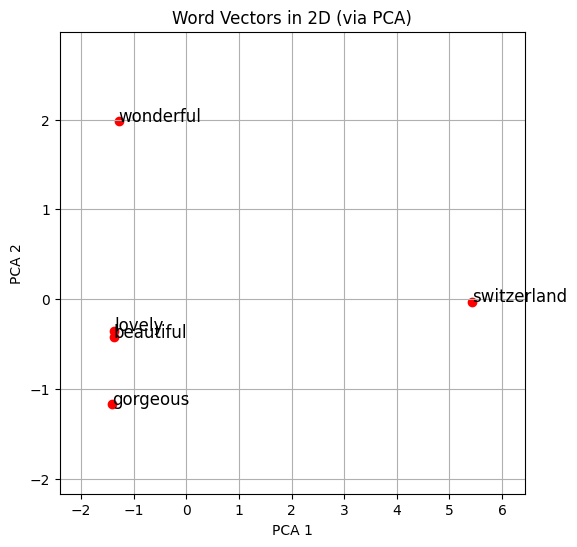

In [21]:
plot_vectors(['beautiful','lovely','gorgeous','wonderful','switzerland'], glove_6b50d)

### Word Analogy

Besides finding similar words,
we can also apply word vectors
to word analogy tasks.
For example,
“man”:“woman”::“son”:“daughter”
is the form of a word analogy:
“man” is to “woman” as “son” is to “daughter”.
Specifically,
the word analogy completion task
can be defined as:
for a word analogy
$a : b :: c : d$, given the first three words $a$, $b$ and $c$, find $d$.
Denote the vector of word $w$ by $\textrm{vec}(w)$.
To complete the analogy,
we will find the word
whose vector is most similar
to the result of $\textrm{vec}(c)+\textrm{vec}(b)-\textrm{vec}(a)$.


In [22]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])]  # Remove unknown words

Let's verify the "male-female" analogy using the loaded word vectors.


In [23]:
get_analogy('man', 'woman', 'son', glove_6b50d)

'daughter'

Explained variance in 2 dimensions:  0.97


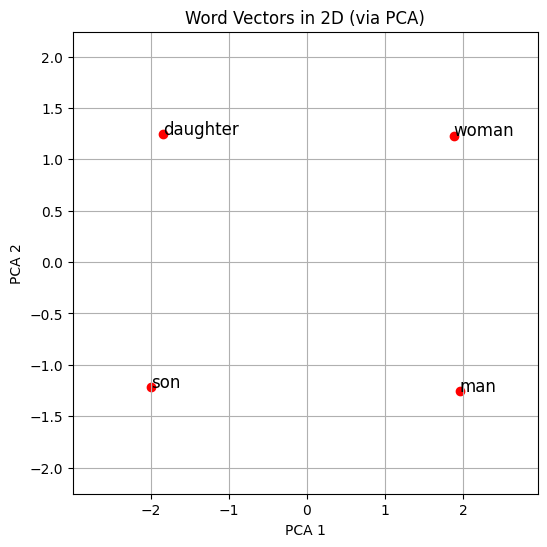

In [24]:
plot_vectors(['man','woman','son','daughter'], glove_6b50d)

Below completes a
“capital-country” analogy:
“beijing”:“china”::“tokyo”:“japan”.
This demonstrates
semantics in the pretrained word vectors.


In [25]:
get_analogy('beijing', 'china', 'tokyo', glove_6b50d)

'japan'

Explained variance in 2 dimensions:  0.93


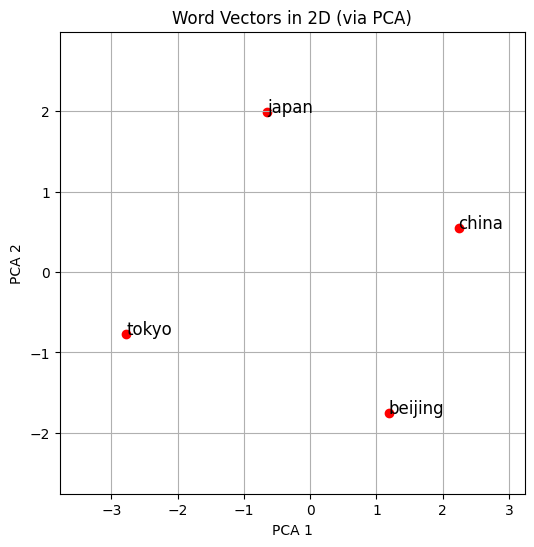

In [26]:
plot_vectors(['beijing', 'china', 'tokyo', 'japan'], glove_6b50d)

For the
“adjective-superlative adjective” analogy
such as
“bad”:“worst”::“big”:“biggest”,
we can see that the pretrained word vectors
may capture the syntactic information.


In [27]:
get_analogy('bad', 'worst', 'big', glove_6b50d)

'biggest'

Explained variance in 2 dimensions:  0.89


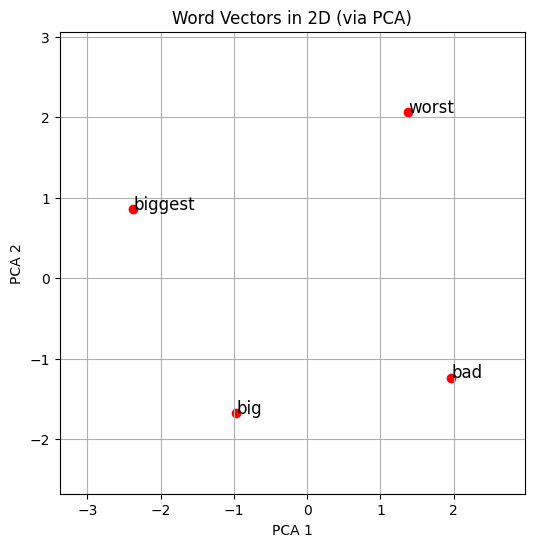

In [28]:
plot_vectors(['bad', 'worst', 'big', 'biggest'], glove_6b50d)

To show the captured notion
of past tense in the pretrained word vectors,
we can test the syntax using the
"present tense-past tense" analogy: “do”:“did”::“go”:“went”.


In [29]:
get_analogy('do', 'did', 'go', glove_6b50d)

'went'

Explained variance in 2 dimensions:  0.95


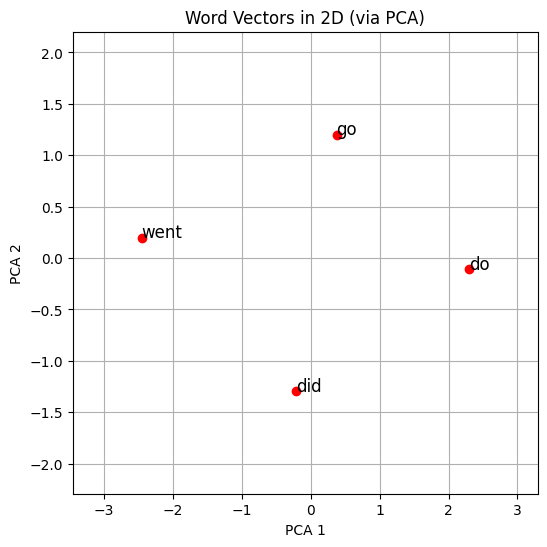

In [30]:
plot_vectors(['do','did','go','went'], glove_6b50d)

In [ ]:
get_analogy('man', 'doctor', 'woman', glove_6b50d)

In [ ]:
plot_vectors(['man','nurse','man','doctor'], glove_6b50d)

## Summary

* In practice, word vectors that are pretrained on large corpora can be applied to downstream natural language processing tasks.
* Pretrained word vectors can be applied to the word similarity and analogy tasks.


## Exercises

1. Test the fastText results using `TokenEmbedding('wiki.en')`.
1. When the vocabulary is extremely large, how can we find similar words or complete a word analogy faster?


[Discussions](https://discuss.d2l.ai/t/1336)
